## **Importing libraries and datasets**

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from xgboost import plot_importance


In [2]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [3]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [4]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [5]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [6]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [7]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})               # Monetary Value           


df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)

In [8]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,15,1012
1,CS1113,36.0,20,1490
2,CS1114,33.0,19,1432
3,CS1115,12.0,22,1659
4,CS1116,204.0,13,857


In [9]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [10]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,62.0,15,1012,1309,67.466667
1,CS1113,36.0,20,1490,1354,74.500000
2,CS1114,33.0,19,1432,1309,75.368421
3,CS1115,12.0,22,1659,1303,75.409091
4,CS1116,204.0,13,857,1155,65.923077


## **Calculating response rate**

In [11]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


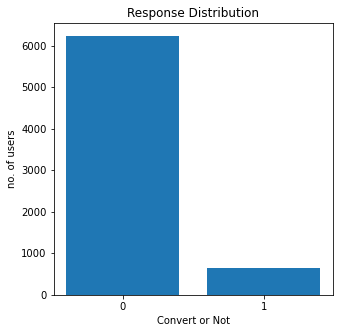

In [12]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [13]:
## merging two data sets - RFM

df_modeling_rfm = pd.merge(df_response,df_rfm)
df_modeling_rfm.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,15,1012
1,CS1113,0,36.0,20,1490
2,CS1114,1,33.0,19,1432
3,CS1115,1,12.0,22,1659
4,CS1116,1,204.0,13,857


In [14]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,0,62.0,15,1012,1309,67.466667
1,CS1113,0,36.0,20,1490,1354,74.500000
2,CS1114,1,33.0,19,1432,1309,75.368421
3,CS1115,1,12.0,22,1659,1303,75.409091
4,CS1116,1,204.0,13,857,1155,65.923077


## **Creating train and test dataset**

In [15]:
## spliting dataframe into X and y

X_rfm = df_modeling_rfm.drop(columns=['response','customer_id'])
y_rfm = df_modeling_rfm['response']

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [16]:
## creating train and test dataset

X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.3, random_state=42)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=42)

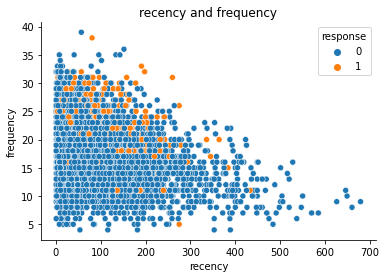

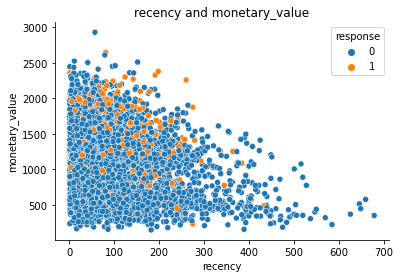

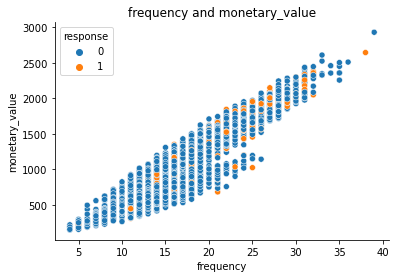

In [17]:
for i, col_i in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
  for j, col_j in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_rfm, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

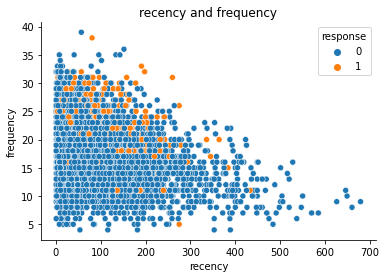

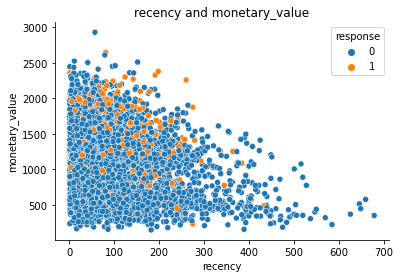

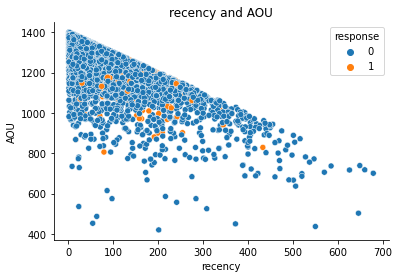

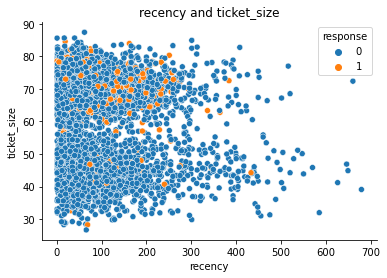

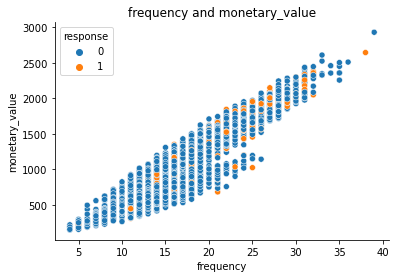

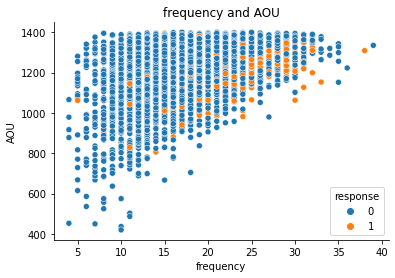

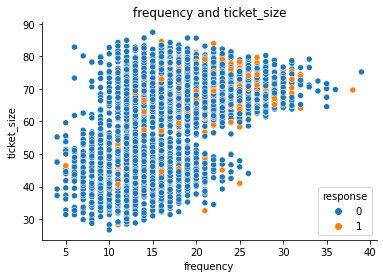

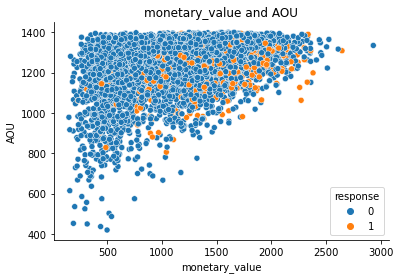

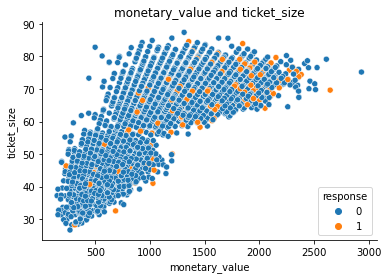

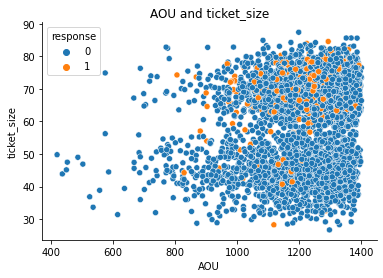

In [18]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

## **Fixing imbalanced with SMOTE**

In [19]:
sm = SMOTE(random_state=10)

sm.fit(X_train_rfm, y_train_rfm)
X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_sample(X_train_rfm, y_train_rfm)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_sample(X_train_clv, y_train_clv)

## **Logistic Regression**

In [20]:
print('logistic regression model - SMOTE RFM')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_rfm = logreg.fit(X_SMOTE_rfm, y_SMOTE_rfm)
predictions = logreg_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)

logistic regression model - SMOTE RFM
training set
              precision    recall  f1-score   support

           0       0.68      0.60      0.64      4376
           1       0.64      0.72      0.68      4376

    accuracy                           0.66      8752
   macro avg       0.66      0.66      0.66      8752
weighted avg       0.66      0.66      0.66      8752

test set
              precision    recall  f1-score   support

           0       0.95      0.59      0.73      1861
           1       0.16      0.72      0.27       205

    accuracy                           0.61      2066
   macro avg       0.56      0.66      0.50      2066
weighted avg       0.87      0.61      0.68      2066



In [21]:
print('logistic regression model - SMOTE CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.68      0.65      0.67      4376
           1       0.67      0.69      0.68      4376

    accuracy                           0.67      8752
   macro avg       0.67      0.67      0.67      8752
weighted avg       0.67      0.67      0.67      8752

test set
              precision    recall  f1-score   support

           0       0.95      0.64      0.76      1861
           1       0.17      0.68      0.27       205

    accuracy                           0.64      2066
   macro avg       0.56      0.66      0.52      2066
weighted avg       0.87      0.64      0.71      2066



# XGBoost

In [22]:
print('XGBoost model - SMOTE RFM')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_rfm = xgb_model.fit(X_SMOTE_rfm, y_SMOTE_rfm, early_stopping_rounds=5, eval_set=[(X_test_rfm, y_test_rfm)])
predictions =  xgb_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_rfm.predict(X_test_rfm.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE RFM


C:\Users\LENOVO\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.57655
[1]	validation_0-auc:0.71650
[2]	validation_0-auc:0.72881
[3]	validation_0-auc:0.72873
[4]	validation_0-auc:0.73029
[5]	validation_0-auc:0.72978
[6]	validation_0-auc:0.73159
[7]	validation_0-auc:0.73035
[8]	validation_0-auc:0.73164
[9]	validation_0-auc:0.73029
[10]	validation_0-auc:0.73024
[11]	validation_0-auc:0.73024
[12]	validation_0-auc:0.73117
[13]	validation_0-auc:0.73170
[14]	validation_0-auc:0.73128
[15]	validation_0-auc:0.73151
[16]	validation_0-auc:0.73217
[17]	validation_0-auc:0.73216
[18]	validation_0-auc:0.73052
[19]	validation_0-auc:0.73029
[20]	validation_0-auc:0.73435
[21]	validation_0-auc:0.73380
[22]	validation_0-auc:0.73486
[23]	validation_0-auc:0.73442
[24]	validation_0-auc:0.73392
[25]	validation_0-auc:0.73412
[26]	validation_0-auc:0.73387
[27]	validation_0-auc:0.73355
training set
              precision    recall  f1-score   support

           0       0.73      0.56      0.63      4376
           1       0.64      0.79      0.71     

In [23]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv, y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.67476
[1]	validation_0-auc:0.71531
[2]	validation_0-auc:0.72394
[3]	validation_0-auc:0.72883
[4]	validation_0-auc:0.72994
[5]	validation_0-auc:0.72957
[6]	validation_0-auc:0.72912
[7]	validation_0-auc:0.73189
[8]	validation_0-auc:0.73283
[9]	validation_0-auc:0.73362
[10]	validation_0-auc:0.73610
[11]	validation_0-auc:0.73355
[12]	validation_0-auc:0.73447
[13]	validation_0-auc:0.73674
[14]	validation_0-auc:0.73552
[15]	validation_0-auc:0.73400
[16]	validation_0-auc:0.73523
[17]	validation_0-auc:0.73522
[18]	validation_0-auc:0.73536
training set
              precision    recall  f1-score   support

           0       0.70      0.60      0.64      4376
           1       0.65      0.75      0.69      4376

    accuracy                           0.67      8752
   macro avg       0.67      0.67      0.67      8752
weighted avg       0.67      0.67      0.67      8752

test set
              precision    recall  f1-score   support

          

# Hyperparameter Tuning

In [24]:
## building pipeline for hyperparameter tuning

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

In [25]:
## hyper parameter tuning - grid search

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(2, 5),
    'clf__colsample_bytree': [i/10.0 for i in range(4, 7)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
kfold = KFold(n_splits=5, random_state=42)
# AUC and F1 as score
scoring = {'AUC':'roc_auc','F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_rfm_GS = grid.fit(X_train_rfm, y_train_rfm)
xgb_model_clv_GS = grid.fit(X_train_clv, y_train_clv)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   55.5s finished
C:\Users\LENOVO\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_

[02:03:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   51.3s finished
C:\Users\LENOVO\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:04:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [26]:
predicted_y = []
expected_y = []
predictions = xgb_model_clv_GS.predict(X_train_clv)

predicted_y.extend(predictions)
expected_y.extend(y_train_clv)
report_test = classification_report(expected_y, predicted_y)
print('training set')
print(report_test) 

predicted_y = []
expected_y = []
predictions = xgb_model_clv_GS.predict(X_test_clv)

predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('testing set')
print(report_test) 

print('Best AUC Score: {}'.format(xgb_model_clv_GS.best_score_))
print(confusion_matrix(y_test_clv, predictions))

training set
              precision    recall  f1-score   support

           0       0.96      0.60      0.74      4376
           1       0.16      0.75      0.26       442

    accuracy                           0.61      4818
   macro avg       0.56      0.67      0.50      4818
weighted avg       0.89      0.61      0.69      4818

testing set
              precision    recall  f1-score   support

           0       0.96      0.57      0.72      1861
           1       0.16      0.76      0.27       205

    accuracy                           0.59      2066
   macro avg       0.56      0.67      0.49      2066
weighted avg       0.88      0.59      0.67      2066

Best AUC Score: 0.6980872123379872
[[1069  792]
 [  50  155]]


In [27]:
print(xgb_model_clv_GS.best_params_)

{'clf__colsample_bytree': 0.4, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 300, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x000002374CDC95E0>}


# CatBoostClassifier

In [28]:
from catboost import CatBoostClassifier
print('CatBoost model - SMOTE RFM')
best_params = {'bagging_temperature': 0.8,
               'depth': 5,
               'iterations': 500,
               'l2_leaf_reg': 30,
               'learning_rate': 0.05,
               'random_strength': 0.8}

model_cat_boost = CatBoostClassifier(
        **best_params,
        loss_function='Logloss',
        eval_metric='Accuracy',         
        nan_mode='Min',
        verbose=False
    )

model_cat_boost.fit(X_SMOTE_rfm, y_SMOTE_rfm)
result = []
y_pred_cat_boost = model_cat_boost.predict(X_test_rfm)
cm_cat_boost = confusion_matrix(y_pred_cat_boost, y_test_rfm)
acc_cat_boost = accuracy_score(y_test_rfm, y_pred_cat_boost)
result.append(acc_cat_boost)
print("RESULT")
print("Cat Boost Model Acc : ",acc_cat_boost)
print(confusion_matrix(y_test_rfm,predictions))

CatBoost model - SMOTE RFM
RESULT
Cat Boost Model Acc :  0.6979670861568248
[[1069  792]
 [  50  155]]


In [29]:
predicted_y = []
expected_y = []
predictions = model_cat_boost.predict(X_SMOTE_rfm)

predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_test = classification_report(expected_y, predicted_y)
print('training set')
print(report_test) 

predicted_y = []
expected_y = []
predictions = model_cat_boost.predict(X_test_rfm)

predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('testing set')
print(report_test) 

training set
              precision    recall  f1-score   support

           0       0.86      0.74      0.80      4376
           1       0.77      0.88      0.82      4376

    accuracy                           0.81      8752
   macro avg       0.82      0.81      0.81      8752
weighted avg       0.82      0.81      0.81      8752

testing set
              precision    recall  f1-score   support

           0       0.93      0.72      0.81      1861
           1       0.17      0.51      0.25       205

    accuracy                           0.70      2066
   macro avg       0.55      0.62      0.53      2066
weighted avg       0.85      0.70      0.76      2066



In [32]:
print('CatBoost model - SMOTE CLV')
best_params = {'bagging_temperature': 0.8,
               'depth': 5,
               'iterations': 500,
               'l2_leaf_reg': 30,
               'learning_rate': 0.05,
               'random_strength': 0.8}

model_cat_boost = CatBoostClassifier(
        **best_params,
        loss_function='Logloss',
        eval_metric='Accuracy',         
        nan_mode='Min',
        verbose=False
    )

model_cat_boost.fit(X_SMOTE_clv, y_SMOTE_clv)
result = []
y_pred_cat_boost = model_cat_boost.predict(X_test_clv)
cm_cat_boost = confusion_matrix(y_pred_cat_boost, y_test_clv)
acc_cat_boost = accuracy_score(y_test_clv, y_pred_cat_boost)
result.append(acc_cat_boost)
print("RESULT")
print("Cat Boost Model Acc : ",acc_cat_boost)
print(confusion_matrix(y_test_clv,predictions))

CatBoost model - SMOTE CLV
RESULT
Cat Boost Model Acc :  0.7013552758954501
[[1337  524]
 [ 100  105]]


In [33]:
predicted_y = []
expected_y = []
predictions = model_cat_boost.predict(X_SMOTE_clv)

predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_test = classification_report(expected_y, predicted_y)
print('training set')
print(report_test) 

predicted_y = []
expected_y = []
predictions = model_cat_boost.predict(X_test_clv)

predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('testing set')
print(report_test) 

training set
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      4376
           1       0.79      0.90      0.84      4376

    accuracy                           0.83      8752
   macro avg       0.84      0.83      0.83      8752
weighted avg       0.84      0.83      0.83      8752

testing set
              precision    recall  f1-score   support

           0       0.93      0.72      0.81      1861
           1       0.17      0.53      0.26       205

    accuracy                           0.70      2066
   macro avg       0.55      0.62      0.54      2066
weighted avg       0.86      0.70      0.76      2066

